Dans ce notebook, le but est d'afficher l'umap des sujets de PEPR_Marseille en fonction de Lesion_type, et ensuite s'afficher l'umap de l'espace résidualisé

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

In [60]:
#On lit les fichiers nécessaires
Embeddings_UKB= pd.read_csv("/neurospin/tmp/fred/models/2025-11-10/SC-sylv_right_UKB_16-20-03_123/Embeddings.csv")
Embeddings_HCP= pd.read_csv("/neurospin/tmp/fred/models/2025-11-10/SC-sylv_right_UKB_16-20-03_123/hcp/Embeddings.csv")
Embeddings_epilepsy= pd.read_csv("/neurospin/tmp/fred/models/2025-11-10/SC-sylv_right_UKB_16-20-03_123/epilepsy_PBS/Embeddings.csv")
Embeddings_PEPR= pd.read_csv("/neurospin/tmp/fred/models/2025-11-10/SC-sylv_right_UKB_16-20-03_123/PEPR_Marseille/Embeddings.csv")

In [61]:
selected_index = np.load("/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/notebooks/fred/PEPR_Marseille/All the subjects/histogram_non_zero/index_to_save.npy")

In [62]:
Embeddings_PEPR = Embeddings_PEPR.loc[selected_index].reset_index(drop=True)

In [63]:
Participants_epilepsy=pd.read_csv("/neurospin/dico/data/human/epilepsy_PBS/participants.tsv", sep="\t")

In [64]:
epilepsy_controls= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="controls"]

In [65]:
#We rename the first colomn 

Embeddings_epilepsy  = Embeddings_epilepsy.rename(columns={Embeddings_epilepsy.columns[0]: "Index"})

In [66]:
Embeddings_controls = Embeddings_epilepsy.merge(epilepsy_controls[["Index"]], on="Index", how="inner")

In [67]:
X1 = Embeddings_UKB.iloc[:,1:76] #We remove de first column because it represents the id
                                 #1:76 because there are 75 components
X2= Embeddings_HCP.iloc[:,1:76]
X3= Embeddings_controls.iloc[:,1:76]
X4= Embeddings_PEPR.iloc[:,1:76]

In [68]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X2=scaler.transform(X2)
X3=scaler.transform(X3)
X4=scaler.transform(X4)

UMAP sur les sujets de PEPR_Marseille en fonction du type de lésion

In [69]:
reducer = umap.UMAP(n_components=2, random_state=42)
X4_umap1 = reducer.fit_transform(X4)


/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [70]:
df_PEPR = pd.read_csv("/neurospin/dico/data/human/PEPR_Marseille/PourTheotime.csv", sep="\t")

In [71]:
df_cross_entropy = pd.read_csv("/neurospin/tmp/fred/models/2025-11-10/SC-sylv_right_UKB_16-20-03_123/PEPR_Marseille/Reconstruction_error.csv")

In [73]:
selected_index_1=[]
for a in df_cross_entropy.iloc[:, 0]:
    if a=="0109GRE_10102016":
        selected_index_1.append(978)
    if a=="0109GRE_12112016":
        selected_index_1.append(979)
    if a=="0164ROT_29012018":
        selected_index_1.append(1158)
    if a=="0168ROT_01032018":
        selected_index_1.append(1172)
    if a=="0168ROT_17092018":
        selected_index_1.append(1173)

    id = a[:7]

    matches = df_PEPR.index[df_PEPR.iloc[:, 0].str[:7] == id]
    if len(matches) == 1:
        selected_index_1.append(matches[0])
    else:
        #print(len(matches))
        j=0
        for i in matches:
            c= len(df_PEPR.iloc[i, 0])
            if c==9:
                id  = a[:7] + a[-2:]
                if df_PEPR.iloc[i, 0]==id:
                    selected_index_1.append(i)
                    j+=1
            elif c==11:
                id = a[:7]+ a[10:12]+a[-2:]
                if df_PEPR.iloc[i, 0]==id:
                    selected_index_1.append(i)
                    j+=1
            elif c==10:
                id = a[:7]+ a[11]+a[-2:]
                if df_PEPR.iloc[i, 0]==id:
                    selected_index_1.append(i)
                    j+=1
            elif c==7:
                selected_index_1.append(747)
                j+=1
selected_index_1= np.array(selected_index_1)

In [74]:
df_cross_entropy = df_cross_entropy.loc[selected_index].reset_index(drop=True)


In [75]:
df_PEPR= df_PEPR.loc[selected_index_1].reset_index(drop=True) #1 ere sélection
df_PEPR= df_PEPR.loc[selected_index].reset_index(drop=True) #2e sélection


In [76]:
Lesion_type = (
    df_PEPR["Lesion type"]
    .astype(str)                           # pour gérer les NaN
    .str.extract(r"^\d+(?:\.\d+)?:\s*(.*)")  # texte après le nombre + :
    .iloc[:, 0]                            # Series (et pas DataFrame)
    .where(df_PEPR["Lesion type"].notna()) # remettre NaN là où il faut
    .tolist()
)
Lesion_type= np.array(Lesion_type)

In [77]:
Lesion_type = Lesion_type.flatten()

In [78]:
# Valeurs uniques non-NaN de Lesion_type

Lesion_type = pd.Series(Lesion_type)

unique_Lesion_type = Lesion_type.dropna().unique()

# Colormap (autant de couleurs que de valeurs uniques)
cmap = plt.cm.tab10  # ou tab20 si beaucoup de valeurs
colors = cmap(np.linspace(0, 1, len(unique_Lesion_type)))

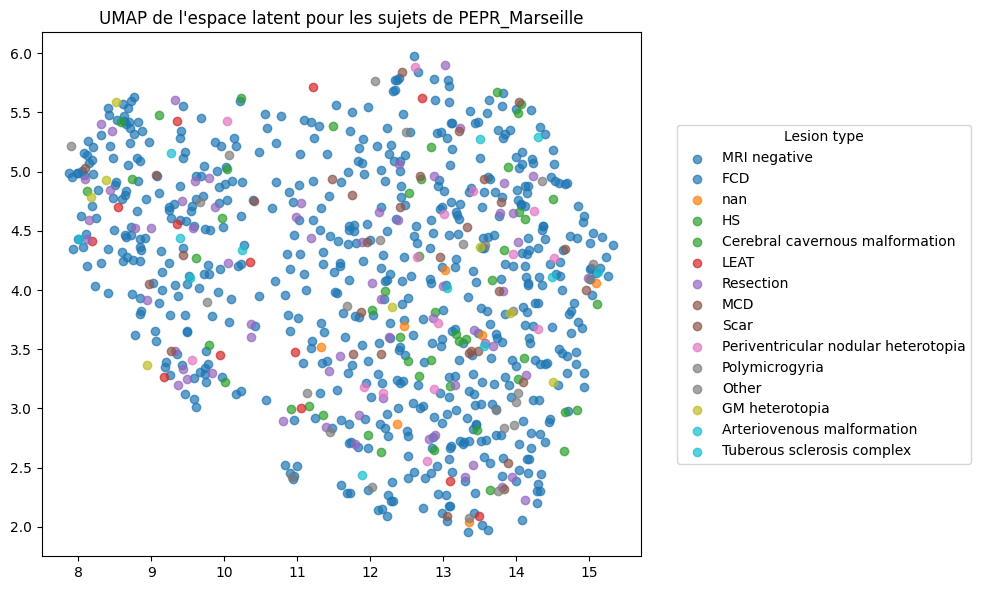

In [79]:
plt.figure(figsize=(10, 6))


# Tracé des points pour chaque valeur de c
for val, col in zip(unique_Lesion_type, colors):
    mask = Lesion_type == val
    plt.scatter(X4_umap1[mask,0], X4_umap1[mask,1], color=col, label=f"{val}", alpha=0.7)

plt.legend(
    title="Lesion type",
    bbox_to_anchor=(1.05, 0.5),
    loc="center left"
)
plt.title("UMAP de l'espace latent pour les sujets de PEPR_Marseille")
plt.tight_layout()
plt.show()


On résidualise

In [80]:
import statsmodels.api as sm

In [81]:
L= np.concatenate((X1,X2,X3,X4), axis=0)

covariates = pd.DataFrame({
    'Site': ['UKB']*len(X1) 
            + ['hcp']*len(X2) 
            + ['epilepsy_PBS']*len(X3) 
            + ['PEPR']*len(X4)
})

In [82]:
covariates = pd.get_dummies(covariates)

In [83]:
covariates_train= covariates.head(len(X1)+len(X2)+len(X3))
covariates_test= covariates.tail(len(X4))

L_train=np.concatenate((X1,X2,X3), axis=0)
L_test= X4

In [84]:
covariates = sm.add_constant(covariates)  # Add intercept

L1_resid = np.zeros_like(L_train)
L2_resid = np.zeros_like(L_test)

for j in range(L_train.shape[1]):
    model = sm.OLS(L_train[:, j].astype(float), covariates_train.astype(float)).fit()
    L1_resid[:, j] = model.resid 
    L2_resid[:, j] = L_test[:,j] - model.predict(covariates_test)


In [85]:
X_ukb = L1_resid[:len(X1),:]
X_hcp = L1_resid[len(X1):len(X1)+len(X2),:]
X_control= L1_resid[len(X1)+len(X2):len(X1)+len(X2)+len(X3),:]
X_PEPR= L2_resid

In [86]:
reducer = umap.UMAP(n_components=2, random_state=42)
X1_umap = reducer.fit_transform(X_ukb)
X4_umap= reducer.transform(X_PEPR)


/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


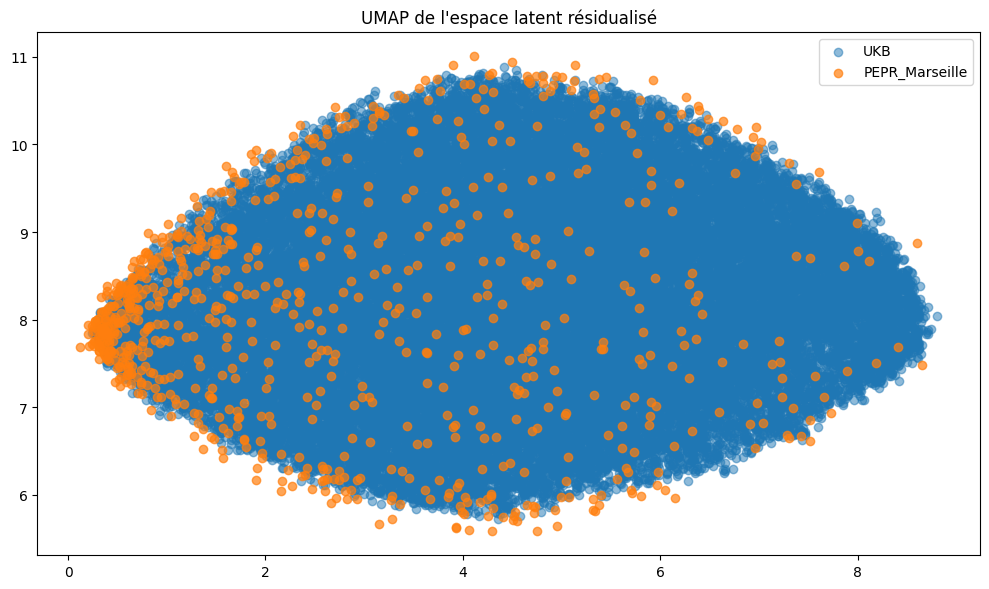

In [87]:
plt.figure(figsize=(10, 6))

plt.scatter(X1_umap[:,0], X1_umap[:,1], label="UKB", alpha=0.5)
plt.scatter(X4_umap[:,0], X4_umap[:,1], label="PEPR_Marseille", alpha=0.7)

plt.legend()

plt.title("UMAP de l'espace latent résidualisé")
plt.tight_layout()
plt.show()
